In [1]:
import mysql.connector
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import json
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [2]:
config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "",
    "database": "ldksyahid_db",
    "port": 3306 
}
conn = mysql.connector.connect(**config)

In [3]:
# Query dataset donasi yang sudah dibayar
query_dataset = "SELECT * FROM ldksyahid_db.ms_donationdataset a WHERE a.payment_status = 'PAID'"
cursor = conn.cursor()
cursor.execute(query_dataset)
fetch_dataset = cursor.fetchall()
cursor.close()

# Definisikan kolom-kolom yang akan digunakan
columns = [
    'id', 'jumlah_donasi', 'nama_donatur', 'email_donatur', 'usia', 'domisili', 
    'pekerjaan', 'no_telp_donatur', 'pesan_donatur', 'captcha', 'metode_pembayaran', 
    'nama_merchant', 'biaya_admin', 'kode_unik', 'campaign_id', 'doc_no', 'payment_status', 
    'payment_link', 'total_tagihan', 'created_at', 'updated_at', 'idInc'
    ]

# Buat DataFrame dari data
dataset = pd.DataFrame(fetch_dataset, columns=columns)
dataset

,id,jumlah_donasi,nama_donatur,email_donatur,usia,domisili,pekerjaan,no_telp_donatur,pesan_donatur,captcha,...,biaya_admin,kode_unik,campaign_id,doc_no,payment_status,payment_link,total_tagihan,created_at,updated_at,idInc
0,de5ce2b7-c44a-368d-b0a8-0e80c28c2f19,100000,Brett Hermiston,brett.hermiston@gmail.com,18,KABUPATEN ROTE NDAO,Nurse Anesthetist,0895394725814,Kita tidak perlu menjadi kaya untuk bisa membe...,FnNBxQlD7wdS1Jne49nOpMNkgRIPBnlNxYgUrkyeR-h720...,...,4000,None,432d1b50-c252-406e-85c6-417b91c90556,soRHDSR179,PAID,https://checkout-staging.xendit.co/v2/3lnzr0jv...,100000,2023-07-17 08:15:00,2023-07-17 08:15:00,1
1,26cf7ff1-57df-3a51-814e-5fa17c5b8bec,50000,Ms Courtney,ms..courtney@gmail.com,22,KOTA SIBOLGA,Penjaga Toko,0895394798274,Dengan senang hati kami turut berkontribusi da...,nup9i7qu91NyJs9zmk5YlmfX38SqCSFWMV5d-ecwJyH1nt...,...,1500,None,009e9829-1556-4325-9eee-bf89f8508f3d,f9iSDAhbOi,PAID,https://checkout-staging.xendit.co/v2/p237es1k...,50000,2023-05-21 16:00:00,2023-05-21 16:00:00,3
2,b62695bd-00db-3d31-a7c4-398ba066f81a,1000000,Dr Stefan,dr..stefan@gmail.com,44,KOTA ADM. JAKARTA SELATAN,Fashion Designer,0895394780878,"Dengan donasi ini, kita memberikan peluang bar...",ZB5ukrGktvj90zy58c-Dpbp3r6v-cpqwgcaqDZqLFRRiPs...,...,1500,None,009e9829-1556-4325-9eee-bf89f8508f3d,vE2pNO04Xf,PAID,https://checkout-staging.xendit.co/v2/jbaximtk...,1000000,2023-05-12 12:30:00,2023-05-12 12:30:00,5
3,8c9485e3-e023-3efb-a062-d7e1befd5070,75000,Rubie Kozey,rubie.kozey@gmail.com,47,KABUPATEN KEPULAUAN SELAYAR,Marine Biologist,0895394784451,Kita tidak pernah tahu seberapa besar dampak y...,yUDy4xrfj0l9fbsLt0LYS0UVa6o5hDDGtMDwh90hDC0dls...,...,1000,None,56b18aea-9d8e-45d6-9d3c-438d1a284fe5,QPXuNvGxXl,PAID,https://checkout-staging.xendit.co/v2/nds3qese...,75000,2023-08-01 08:00:00,2023-08-01 08:00:00,6
4,34b00694-db86-3570-82ad-11bc7d57bc85,10000,Miss Lorna,miss.lorna@gmail.com,49,KABUPATEN DAIRI,Historian,0895394788576,Setiap tetes sumbangan Anda adalah tetes air y...,ryDtfII6cZmp2zCw8I792N7SkREq7cutRfuTSSZCv4UWKd...,...,2500,None,432d1b50-c252-406e-85c6-417b91c90556,voC6uz3JwW,PAID,https://checkout-staging.xendit.co/v2/bgx0q7ut...,10000,2023-06-08 08:30:00,2023-06-08 08:30:00,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,e2b64298-a8c7-3bf3-a367-6f4708422eba,500000,Santiago,santiago75@gmail.com,29,KABUPATEN PANGKAJENE KEPULAUAN,Nutritionist,0895394759538,Donasi adalah bentuk kasih sayang yang dapat m...,upvyt0UjqZHGjvEQG5Ye5RAvPU3GHpJNfT0aUfE1ois0jZ...,...,1500,None,56b18aea-9d8e-45d6-9d3c-438d1a284fe5,LMH1IqYeDz,PAID,https://checkout-staging.xendit.co/v2/1q65ajeb...,500000,2023-04-20 12:30:00,2023-04-20 12:30:00,6370
3780,8c7e7b42-cccb-35ac-a18f-787c69d1a0b8,10000,Tatyana Bradtke,tatyana.bradtke@gmail.com,29,KABUPATEN BINTAN,Content Creator,0895394735533,"Dalam setiap langkah kebaikan, ada cahaya yang...",1SEhtTVrzhq19RuGpVuOEjOb6zIfcRZC00s-TKF979PKiE...,...,3000,None,56b18aea-9d8e-45d6-9d3c-438d1a284fe5,HNvIFXy3tJ,PAID,https://checkout-staging.xendit.co/v2/hbgpx05c...,10000,2023-06-11 12:00:00,2023-06-11 12:00:00,6371
3781,44f33c90-2302-346c-b7a6-5325c49cc6cd,50000,Corine Altenwerth,corine.altenwerth@gmail.com,29,KABUPATEN KARANGANYAR,Geophysicist,089539477781,Semoga amal ibadah ini diterima dengan baik ol...,RDcP2t3Nj42ceAOzISj9QVvYRS8bxq-TpGBSAbWsGmDcjB...,...,3500,None,009e9829-1556-4325-9eee-bf89f8508f3d,bJXH61hVXT,PAID,https://checkout-staging.xendit.co/v2/ttrnofzt...,50000,2023-05-31 20:15:00,2023-05-31 20:15:00,6372
3782,6428d52a-e465-3a16-b7bd-534c211b0f15,30000,Ms Kathryn,ms..kathryn@gmail.com,47,KABUPATEN TANAH BUMBU,Archaeologist,0895394783300,"Dalam dunia yang serba cepat, donasi adalah be...",da9vge2AUwpu67OiZRu-tuigpMhkZ-mQ1qa4QNpZC4hb6o...,...,2000,None,56b18aea-9d8e-45d6-9d3c-438d1a284fe5,lGTNpIdbbB,PAID,https://checkout-staging.xendit.co/v2/b8l8wvuh...,30000,2023-01-02 16:45:00,2023-01-02 16:45:00,6373


In [4]:
# Buat fungsi untuk mengklasifikasikan jumlah donasi ke dalam kelas
def classify_donation(donation_amount):
    if donation_amount <= 25000:
        return 0
    elif donation_amount <= 50000:
        return 1
    elif donation_amount <= 100000:
        return 2
    elif donation_amount <= 250000:
        return 3
    else:
        return 4

# Tambahkan kolom klasifikasi berdasarkan jumlah donasi
dataset['donation_class'] = dataset['jumlah_donasi'].astype(int).apply(classify_donation)
dataset['donation_class']

0       2
1       1
2       4
3       2
4       0
       ..
3779    4
3780    0
3781    1
3782    1
3783    2
Name: donation_class, Length: 3784, dtype: int64

In [5]:
# Pilih fitur untuk klasifikasi
classification_features = dataset[['usia', 'donation_class', 'jumlah_donasi']]
X = classification_features[['usia', 'jumlah_donasi']]
y = dataset['donation_class'] 

In [6]:
X = classification_features[['usia', 'jumlah_donasi']]
y = dataset['donation_class'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])
total_data = X_train.shape[0] + X_test.shape[0]
print("Total jumlah data:", total_data)

Jumlah data latih: 3027
Jumlah data uji: 757
Total jumlah data: 3784


In [8]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Model training
model = SVC(random_state=0, class_weight='balanced')
model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', random_state=0)

In [10]:
# Model evaluation
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       213
           1       0.99      0.56      0.72       133
           2       1.00      1.00      1.00       112
           3       1.00      1.00      1.00       109
           4       1.00      1.00      1.00       190

    accuracy                           0.92       757
   macro avg       0.95      0.91      0.92       757
weighted avg       0.94      0.92      0.92       757



In [11]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning using GridSearchCV
parameters = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=SVC(random_state=0),
                           param_grid=parameters,
                           n_jobs=-1,
                           verbose=1,
                           scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

print(f'Best Score: {grid_search.best_score_}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Score: 1.0


In [12]:
best_params = grid_search.best_estimator_.get_params()
print('Best Parameters:')
for param in parameters:
    print(f'\t{param}: {best_params[param]}')

Best Parameters:
	kernel: poly
	C: 10
	gamma: 1


In [13]:
# Evaluate the model with the best parameters
y_pred = grid_search.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       133
           2       1.00      1.00      1.00       112
           3       1.00      1.00      1.00       109
           4       1.00      1.00      1.00       190

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



In [25]:
import pandas as pd

# Prediksi model sebelum dan setelah penyetelan parameter
y_pred_before = model.predict(X_test_scaled)
y_pred_after = grid_search.predict(X_test_scaled)

# Buat DataFrame untuk menyimpan data donasi beserta hasil prediksi sebelum dan setelah penyetelan parameter
df_results = pd.DataFrame({
    'Label Asli': y_test,
    'Prediksi Sebelum Tuning': y_pred_before,
    'Prediksi Setelah Tuning': y_pred_after
})

# Temukan baris di mana prediksi sebelum dan setelah penyetelan parameter tidak cocok
mismatched_data = df_results[df_results['Prediksi Sebelum Tuning'] != df_results['Prediksi Setelah Tuning']]

# Masukkan Label yang ingin di lihat klasifikasinya
label_input = 1

# Filter hanya data dengan label asli yang ditentukan
mismatched_data_label_input = mismatched_data[mismatched_data['Label Asli'] == label_input]

# Hitung total data yang gagal diklasifikasikan untuk label asli yang ditentukan
total_mismatched_label_input = mismatched_data_label_input.shape[0]

# Tampilkan data donasi dengan label asli yang ditentukan yang gagal diklasifikasikan beserta total datanya
print("Data donasi dengan label asli", label_input, "yang gagal diklasifikasi:")
print(mismatched_data_label_input)
print("\nTotal data dengan label asli", label_input, "yang gagal diklasifikasikan:", total_mismatched_label_input)

Data donasi dengan label asli 1 yang gagal diklasifikasi:
      Label Asli  Prediksi Sebelum Tuning  Prediksi Setelah Tuning
526            1                        0                        1
2664           1                        0                        1
3266           1                        0                        1
3150           1                        0                        1
2966           1                        0                        1
2368           1                        0                        1
543            1                        0                        1
1242           1                        0                        1
39             1                        0                        1
566            1                        0                        1
1939           1                        0                        1
2774           1                        0                        1
3019           1                        0                        1
224 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

# Function to plot decision boundaries with customizable background color
def plot_decision_boundary(X, y, model, title, background_colors=['red', 'yellow', 'green', 'blue', 'orange']):
    h = .02  # step size in the mesh

    # Create a mesh grid
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Make predictions on mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries with customizable background color
    plt.contourf(xx, yy, Z, cmap=ListedColormap(background_colors), alpha=0.5)

    # Plot data points
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

    # Add legend
    legend = plt.legend(*scatter.legend_elements(), title="Kelas Donasi")
    plt.title(title)

    # Add information about total data and data per class
    class_counts = y.value_counts().sort_index()
    total_data = len(y)
    class_info = "\n".join([f"Kelas {class_label}: {count} data" for class_label, count in class_counts.items()])
    plt.text(x_max - 0.5, y_min + 0.5, f"Total Data: {total_data}\n{class_info}", fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# List warna untuk setiap area keputusan (sesuai dengan urutan kelas)
background_colors = ['red', 'yellow', 'green', 'blue', 'orange']


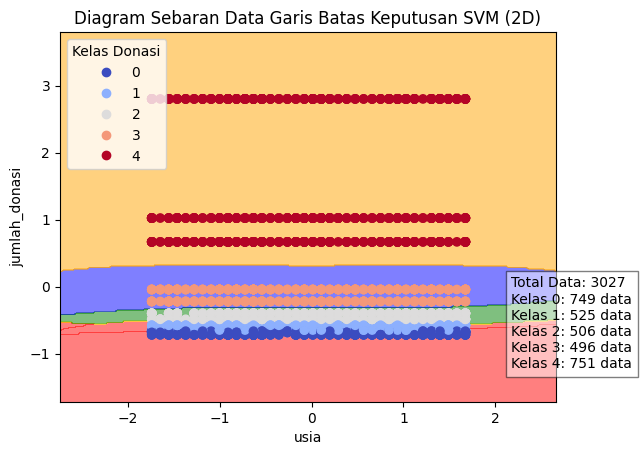

In [16]:
# Visualize decision boundary using the new model dengan warna latar belakang yang berbeda untuk setiap kelas
plot_decision_boundary(pd.DataFrame(X_train_scaled, columns=X.columns[:2]), y_train, model, "Diagram Sebaran Data Garis Batas Keputusan SVM (2D)", background_colors)

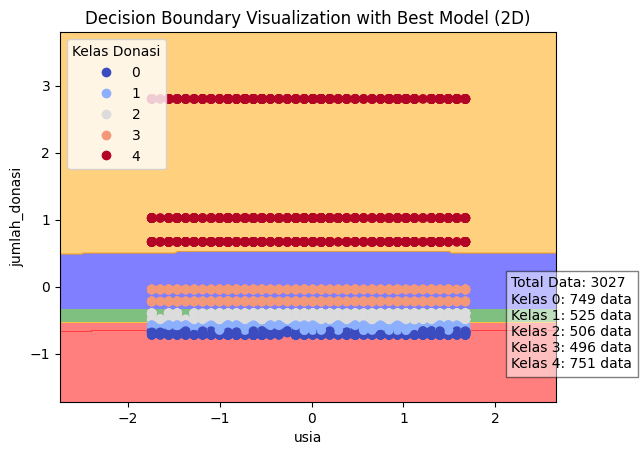

In [17]:
# Extract the best estimator from grid_search
best_model = grid_search.best_estimator_

# Visualize decision boundary using the best model found by GridSearchCV with different background colors for each class
plot_decision_boundary(pd.DataFrame(X_train_scaled, columns=X.columns[:2]), y_train, best_model, "Decision Boundary Visualization with Best Model (2D)", background_colors)


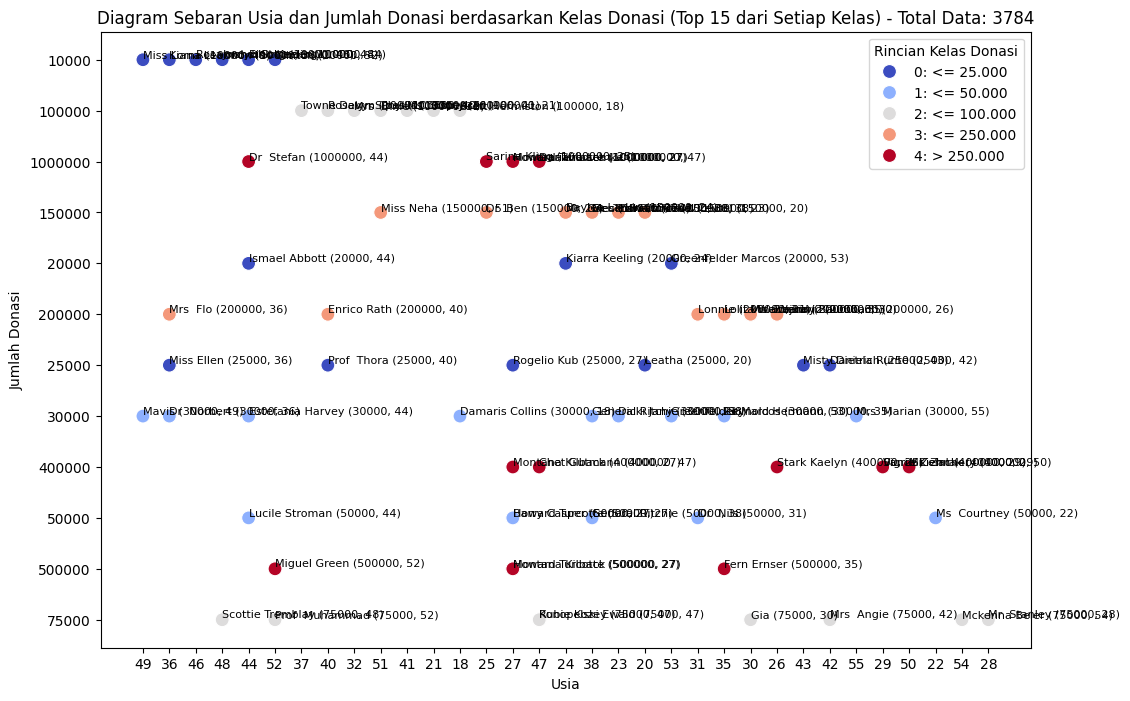

In [18]:
import seaborn as sns

# Tentukan warna untuk setiap kelas donasi
color_palette = {0: '#3b4cc0', 1: '#8db0fe', 2: '#dddcdc', 3: '#f4987a', 4: '#b40426'}

# Ambil 15 data dari setiap kelas donasi
dataset_subset = pd.DataFrame()

for donation_class in range(5):  # Sesuaikan dengan jumlah kelas donasi yang Anda tentukan
    subset_data = dataset[dataset['donation_class'] == donation_class].head(15)
    dataset_subset = pd.concat([dataset_subset, subset_data], ignore_index=True)

# Sortir subset dataset berdasarkan 'jumlah_donasi'
dataset_subset = dataset_subset.sort_values(by='jumlah_donasi')

# Scatter plot untuk Usia dan Jumlah Donasi berdasarkan Kelas Donasi dengan palet warna kustom
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    x='usia', y='jumlah_donasi', hue='donation_class',
    data=dataset_subset, palette=color_palette, s=100
)

# Anotasi titik-titik dengan nama donor
for index, row in dataset_subset.iterrows():
    label = f"{row['nama_donatur']} ({row['jumlah_donasi']}, {row['usia']})"
    scatter_plot.text(row['usia'], row['jumlah_donasi'], label, fontsize=8, ha='left', va='bottom')

# Mengganti judul legenda
scatter_plot.legend(title='Kelas Donasi')

# Menambahkan informasi jumlah data pada judul
plt.title(f'Diagram Sebaran Usia dan Jumlah Donasi berdasarkan Kelas Donasi (Top 15 dari Setiap Kelas) - Total Data: {len(dataset)}')
plt.xlabel('Usia')
plt.ylabel('Jumlah Donasi')

# Menambahkan legenda kelas donasi
handles, labels = scatter_plot.get_legend_handles_labels()
donation_class_labels = {
    0: '<= 25.000',
    1: '<= 50.000',
    2: '<= 100.000',
    3: '<= 250.000',
    4: '> 250.000'
}
leg = plt.legend(handles=handles, labels=[f'{label}: {donation_class_labels[int(label)]}' for label in labels])

# Memberikan judul pada legenda
leg.set_title('Rincian Kelas Donasi')

plt.show()


In [19]:
# Mengambil parameter terbaik dari hasil GridSearchCV
best_params = grid_search.best_estimator_.get_params()

# Menghapus parameter 'random_state' dari best_params
best_params.pop('random_state', None)

# Membuat model dengan parameter terbaik
best_model = SVC(random_state=0, **best_params)

# Pelatihan model dengan data latih
best_model.fit(X_train_scaled, y_train)

# Plot kurva pembelajaran
plot_learning_curve(best_model, "Kurva Pembelajaran (SVM, Poly Kernel)", X_train_scaled, y_train, ylim=(0.7, 1.01), cv=5, n_jobs=-1)

plt.show()


NameError: name 'plot_learning_curve' is not defined